In [73]:
import torch
from torchvision import datasets,transforms
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import classification_report,confusion_matrix
from matplotlib import pyplot as plt
import cv2
import datetime
import random
from torch.utils.data import Subset,DataLoader
import time
from PIL import Image 

In [2]:
#properties of images
size_img = 32 

In [20]:
#get the dataset
transform_initial=transforms.Compose([transforms.Resize((size_img,size_img)),transforms.ToTensor()])
train_dataset=datasets.ImageFolder(root="../../../Fall'21/Advanced computer vision/HW4/data/train/img",transform=transform_initial)
print(len(train_dataset))

5000


In [21]:
#normalizing the datasets. first calculate mean and std for each channel in each training image and take
#the average of those values. Then normalize train,test,val datasets using these computed values from training dataset.
train_dataloader=DataLoader(train_dataset,batch_size=len(train_dataset),
                                    shuffle=True,
                                    num_workers=4)
images, labels = next(iter(train_dataloader))

mean = torch.mean(images, dim=(0, 2, 3))  # Calculate mean across all images and channels
std = torch.std(images, dim=(0, 2, 3))   # Calculate std across all images and channels


In [22]:
#now normalize the datasets using these values of mean and std for each channel
data_transform_normalize = transforms.Compose([transforms.Resize((size_img,size_img)),transforms.ToTensor(),transforms.Normalize(mean,std)])

train_dataset=datasets.ImageFolder(root="../../../Fall'21/Advanced computer vision/HW4/data/train/img",transform=data_transform_normalize)


In [24]:
test_dataset=datasets.ImageFolder(root="../../../Fall'21/Advanced computer vision/HW4/data/test/img",transform=data_transform_normalize)

#splitting test dataset into test+val dataset such that each class in test and validation dataset has 
# 500 and 300 images respectively. 
dataset_size = len(test_dataset)   
val_idx=[]
test_idx=[]
for i in range(0, 8000, 800):
    temp=random.sample(range(i,i+800),800)    
    val_idx+=temp[0:300]
    test_idx+=temp[300:800]
val_dataset=Subset(test_dataset, val_idx)
test_dataset=Subset(test_dataset,test_idx)
print("Test dataset:",len(test_dataset))
print("Validation dataset:",len(val_dataset))

Test dataset: 5000
Validation dataset: 3000


In [25]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        
        #initialize first layer:conv->relu-->maxpooling
        self.conv1=nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #initialize second layer:conv->relu-->maxpooling
        self.conv2=nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2=nn.ReLU()
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #initialize third layer:FC layer-->relu
        self.fc1=nn.Linear(in_features=16*5*5, out_features=120)
        self.relu3=nn.ReLU()
        
        #initialize fourth layer:FC layer-->relu
        self.fc2=nn.Linear(in_features=120, out_features=84)
        self.relu4=nn.ReLU()
        
        #initialize fifth layer:FC layer-->logSoftMax
        self.fc3=nn.Linear(in_features=84, out_features=10)
        self.logSoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self,x):
        #passing the input through first set of layers
        x=self.conv1(x)
        x=self.relu1(x)
        x=self.pool1(x)
        
        #passing output from first layer through second set of layers
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.pool2(x)
        
        #passing output from second layer through third set of layers
        x=torch.flatten(x,1)
        x=self.fc1(x)
        x=self.relu3(x)
        
        #passing output from third layer through fourth set of layers
        x=self.fc2(x)
        x=self.relu4(x)
        
        #passing output from fourth layer through fifth set of layers
        x=self.fc3(x)
        output = self.logSoftmax(x)
        return output

In [26]:
class LeNet5_BN(nn.Module):
    def __init__(self):
        super().__init__()
        
        #initialize first layer:conv->BatchNormalization-->relu-->maxpooling
        self.conv1=nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1=nn.BatchNorm2d(6)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #initialize second layer:conv->BatchNormalization-->relu-->maxpooling
        self.conv2=nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.bn2=nn.BatchNorm2d(16)
        self.relu2=nn.ReLU()
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #initialize third layer:FC layer-->BatchNormalization-->relu
        self.fc1=nn.Linear(in_features=16*5*5, out_features=120)
        self.bn3=nn.BatchNorm1d(120)
        self.relu3=nn.ReLU()
        
        #initialize fourth layer:FC layer-->BatchNormalization-->relu
        self.fc2=nn.Linear(in_features=120, out_features=84)
        self.bn4=nn.BatchNorm1d(84)
        self.relu4=nn.ReLU()
        
        #initialize fifth layer:FC layer-->logSoftMax
        self.fc3=nn.Linear(in_features=84, out_features=10)
        self.logSoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self,x):
        #passing the input through first set of layers
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu1(x)
        x=self.pool1(x)
        
        #passing output from first layer through second set of layers
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu2(x)
        x=self.pool2(x)
        
        #passing output from second layer through third set of layers
        x=torch.flatten(x,1)
        x=self.fc1(x)
        x=self.bn3(x)
        x=self.relu3(x)
        
        #passing output from third layer through fourth set of layers
        x=self.fc2(x)
        x=self.bn4(x)
        x=self.relu4(x)
        
        #passing output from fourth layer through fifth set of layers
        x=self.fc3(x)
        output = self.logSoftmax(x)
        return output


In [27]:
def experiment(train_data,test_data,val_data,model_version,epochs,batchsize,learning_rate):
    
    # initializing the train, validation, and test data loaders with given batchsize
    trainDataLoader = DataLoader(train_data, shuffle=True,batch_size=batchsize)
    valDataLoader = DataLoader(val_data, batch_size=batchsize)
    testDataLoader = DataLoader(test_data, batch_size=batchsize)
    
    # steps per epoch for train and validation set
    trainSteps = len(trainDataLoader.dataset) // batchsize
    valSteps = len(valDataLoader.dataset) // batchsize
    
    #initialize the model
    print("//...Initializing {} model...//".format(model_version))
    #model= LeNet5()
    model=model_version()
    
    #defining optimizer and cross-entropy loss function
    optimizer=Adam(model.parameters(),lr=learning_rate)
    criterion=nn.CrossEntropyLoss()
    
    #Learning rate will reduce by factor of 50% after every step size of 20epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    #empty dict to store losses and accuracy score
    myDict={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}
    
    #initialize training the model
    print("//....Training initiated...//")
    start=time.time()
    
    for epo in range(0,epochs):
        model.train()
        trainLoss=0
        trainCorrect=0
        valLoss=0
        valCorrect=0
        for (x,y) in trainDataLoader:
            optimizer.zero_grad()
            ytrain_pred=model(x)
            loss=criterion(ytrain_pred,y)
            loss.backward()
            optimizer.step()
            trainLoss+=loss
            correct_train=(ytrain_pred.argmax(1)==y).type(torch.float).sum().item()
            trainCorrect=correct_train+trainCorrect
        with torch.no_grad():
            model.eval()
            for (x,y) in valDataLoader:
                yval_pred=model(x)
                loss=criterion(yval_pred,y)
                valLoss+=loss
                correct_val=(yval_pred.argmax(1)==y).type(torch.float).sum().item()
                valCorrect=correct_val+valCorrect
        scheduler.step()
        
        #calculating loss and accuracy for each epoch for both train and val sets
        trainLoss_avg=trainLoss/trainSteps
        valLoss_avg=valLoss/valSteps
        train_acc=trainCorrect/(len(trainDataLoader.dataset))
        val_acc=valCorrect/(len(valDataLoader.dataset))
        
        myDict["train_loss"].append(trainLoss_avg.cpu().detach().numpy())
        myDict["val_loss"].append(valLoss_avg.cpu().detach().numpy())
        myDict["train_acc"].append(train_acc)
        myDict["val_acc"].append(val_acc)
    
        print("//... epoch: {}/{}".format(epo + 1, epochs))
        print("Training loss: {:.4f}, Train accuracy: {:.2f}".format(trainLoss_avg, train_acc))
        print("Validation loss: {:.4f}, Validation accuracy: {:.2f}\n".format(valLoss_avg, val_acc))
    
    end=time.time()
    print("//...training the network took {:.2f} sec...//".format(end-start))
    
    #Evaluation of trained model on test set
    with torch.no_grad():
        model.eval()
        ytest_pred=[]
        ytrue=[]
        for (x,y) in testDataLoader:
            y_pred=model(x)
            ytest_pred.extend(y_pred.argmax(axis=1).numpy())
            ytrue.extend(y.numpy())
            
    #print("y_pred",ytest_pred)
    #print("y_true",ytrue)
    
    class_names = train_data.classes
    label_name = {'1': 'airplane', '2':'bird', '3':'car', '4':'cat', '5':'deer', '6':'dog', '7':'horse', '8':'monkey', '9':'ship', '10':'truck'}
    target_label=[]
    for i in class_names:
        target_label.append(label_name[i])
    #print("clas_names",class_names)
    #print("target_label",target_label)
    
    print(classification_report(ytrue,ytest_pred,target_names=target_label))
    print("//...Confusion Matrix...//")
    print(confusion_matrix(ytrue, ytest_pred, labels=[x for x in range(10)]))
    
    #plotting loss and acc
    plt.style.use("ggplot")
    plt.figure(2)
    plt.plot(myDict["train_loss"], label="train_loss")
    plt.plot(myDict["val_loss"], label="val_loss")
    plt.plot(myDict["train_acc"], label="train_acc")
    plt.plot(myDict["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy: {} model".format(type(model).__name__))
    plt.xlabel("# of Epochs")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    
    return model

//...Initializing <class '__main__.LeNet5'> model...//
//....Training initiated...//
//... epoch: 1/40
Training loss: 2.1510, Train accuracy: 0.20
Validation loss: 1.9950, Validation accuracy: 0.26

//... epoch: 2/40
Training loss: 1.8490, Train accuracy: 0.29
Validation loss: 1.8280, Validation accuracy: 0.33

//... epoch: 3/40
Training loss: 1.7371, Train accuracy: 0.34
Validation loss: 1.7540, Validation accuracy: 0.35

//... epoch: 4/40
Training loss: 1.6730, Train accuracy: 0.37
Validation loss: 1.7081, Validation accuracy: 0.37

//... epoch: 5/40
Training loss: 1.6219, Train accuracy: 0.38
Validation loss: 1.6470, Validation accuracy: 0.39

//... epoch: 6/40
Training loss: 1.5587, Train accuracy: 0.42
Validation loss: 1.7689, Validation accuracy: 0.36

//... epoch: 7/40
Training loss: 1.5688, Train accuracy: 0.42
Validation loss: 1.6320, Validation accuracy: 0.40

//... epoch: 8/40
Training loss: 1.4911, Train accuracy: 0.44
Validation loss: 1.6582, Validation accuracy: 0.41

//.

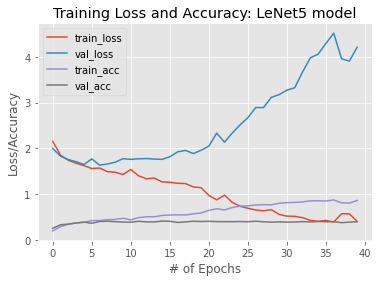

In [46]:
model_1=experiment(train_dataset,test_dataset,val_dataset,LeNet5,40,128,0.01)
idx=datetime.datetime.now()
dt_string = idx.strftime('%d_%m_%Y_%H_%M_%S')
torch.save(model_1.state_dict(), 'LeNet5_model_{}.pth'.format(dt_string))

//...Initializing <class '__main__.LeNet5_BN'> model...//
//....Training initiated...//
//... epoch: 1/40
Training loss: 1.7705, Train accuracy: 0.36
Validation loss: 1.8544, Validation accuracy: 0.34

//... epoch: 2/40
Training loss: 1.5207, Train accuracy: 0.45
Validation loss: 1.6673, Validation accuracy: 0.41

//... epoch: 3/40
Training loss: 1.4190, Train accuracy: 0.48
Validation loss: 1.7212, Validation accuracy: 0.41

//... epoch: 4/40
Training loss: 1.3237, Train accuracy: 0.52
Validation loss: 1.5945, Validation accuracy: 0.43

//... epoch: 5/40
Training loss: 1.2244, Train accuracy: 0.56
Validation loss: 1.5425, Validation accuracy: 0.47

//... epoch: 6/40
Training loss: 1.0615, Train accuracy: 0.61
Validation loss: 1.5579, Validation accuracy: 0.48

//... epoch: 7/40
Training loss: 1.0223, Train accuracy: 0.64
Validation loss: 2.0125, Validation accuracy: 0.41

//... epoch: 8/40
Training loss: 1.0238, Train accuracy: 0.64
Validation loss: 1.6174, Validation accuracy: 0.48



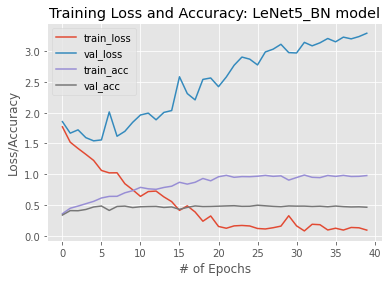

In [47]:
model_2=experiment(train_dataset,test_dataset,val_dataset,LeNet5_BN,40,128,0.01)
idx=datetime.datetime.now()
dt_string = idx.strftime('%d_%m_%Y_%H_%M_%S')
torch.save(model_2.state_dict(), 'LeNet5_BN_model_{}.pth'.format(dt_string))

In [ ]:
model = LeNet5()  # Instantiate the model again with the same structure
model.load_state_dict(torch.load('custom_model.pth'))
model.eval()

In [69]:
#test prediction on an image
img_pred=cv2.imread("../../../Fall'21/Advanced computer vision/HW4/data/test/img/1/10.png")
img_pred=cv2.resize(img_pred, (32, 32), interpolation = cv2.INTER_LINEAR)
cv2.imshow("example",img_pred)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [81]:
#Convert BGR image to RGB image 
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB) 
  
# Define a transform to convert 
# the image to torch tensor 
transform_inference= transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)]) 
  
# Convert the image to Torch tensor 
tensor = transform_inference(img_pred)
tensor=tensor.unsqueeze(0)
print(tensor)
model_2.eval()
pred_lab=model_2(tensor)
print(pred_lab)
print(torch.argmax(-pred_lab))

tensor([[[[ 0.6169,  0.6169,  0.6169,  ...,  0.6007,  0.5845,  0.5683],
          [ 0.6331,  0.6331,  0.6169,  ...,  0.6007,  0.5845,  0.5845],
          [ 0.6169,  0.6331,  0.6331,  ...,  0.6169,  0.6007,  0.6169],
          ...,
          [ 0.6656,  0.6331,  0.6818,  ...,  0.6331,  0.6331,  0.6331],
          [ 0.6494,  0.6980,  0.6656,  ...,  0.6656,  0.6331,  0.6494],
          [ 0.6331,  0.6494,  0.6818,  ...,  0.6494,  0.6494,  0.6331]],

         [[-0.3648, -0.3484, -0.3484,  ..., -0.3648, -0.3977, -0.3813],
          [-0.3319, -0.3155, -0.3484,  ..., -0.3648, -0.3813, -0.3648],
          [-0.3484, -0.3484, -0.3319,  ..., -0.3648, -0.3813, -0.3648],
          ...,
          [-0.2826, -0.2990, -0.2826,  ..., -0.3155, -0.3319, -0.3155],
          [-0.2826, -0.2826, -0.2990,  ..., -0.2990, -0.3319, -0.3319],
          [-0.3319, -0.2990, -0.2990,  ..., -0.3155, -0.3155, -0.3319]],

         [[-0.8600, -0.8754, -0.8600,  ..., -0.9063, -0.8754, -0.9217],
          [-0.8600, -0.8754, -

In [94]:
# Read a PIL image 
image = Image.open("../../../Fall'21/Advanced computer vision/HW4/data/test/img/1/10.png") 
  
# Define a transform to convert PIL  
# image to a Torch tensor 
transform_inference_PIL = transforms.Compose([transforms.Resize((32,32))])
  
# Convert the PIL image to Torch tensor 
img_tensor = transform_inference_PIL(image)
img_tensor = transforms.functional.to_tensor(img_tensor)

print(img_tensor)
img_tensor=img_tensor.unsqueeze(0)

tensor([[[0.1882, 0.1843, 0.1843,  ..., 0.1843, 0.1843, 0.1804],
         [0.1882, 0.1843, 0.1843,  ..., 0.1843, 0.1843, 0.1843],
         [0.1882, 0.1882, 0.1843,  ..., 0.1882, 0.1882, 0.1843],
         ...,
         [0.1882, 0.1843, 0.1882,  ..., 0.1882, 0.1922, 0.1922],
         [0.1882, 0.1843, 0.1882,  ..., 0.1922, 0.1961, 0.1961],
         [0.1882, 0.1882, 0.1843,  ..., 0.1961, 0.1922, 0.1882]],

        [[0.3569, 0.3569, 0.3569,  ..., 0.3529, 0.3490, 0.3490],
         [0.3569, 0.3608, 0.3608,  ..., 0.3529, 0.3529, 0.3529],
         [0.3569, 0.3608, 0.3608,  ..., 0.3529, 0.3490, 0.3529],
         ...,
         [0.3686, 0.3686, 0.3686,  ..., 0.3647, 0.3647, 0.3647],
         [0.3686, 0.3686, 0.3686,  ..., 0.3647, 0.3647, 0.3647],
         [0.3647, 0.3686, 0.3686,  ..., 0.3647, 0.3647, 0.3647]],

        [[0.5961, 0.5961, 0.5961,  ..., 0.5922, 0.5922, 0.5882],
         [0.5961, 0.5961, 0.5961,  ..., 0.5922, 0.5882, 0.5882],
         [0.6000, 0.6000, 0.6000,  ..., 0.5922, 0.5922, 0.

In [95]:
model_2.eval()
pred_lab=model_2(img_tensor)
print(pred_lab)
print(torch.argmax(-pred_lab))

tensor([[ -6.6742,  -3.9285,  -5.4225, -14.8905,  -2.0537,  -1.2539,  -3.3042,
          -7.9649,  -1.0180,  -1.8163]], grad_fn=<LogSoftmaxBackward>)
tensor(3)


In [99]:
train_dataloader_dummy=DataLoader(train_dataset,batch_size=len(train_dataset),
                                    shuffle=True,
                                    num_workers=4)
_, labels_dummy = next(iter(train_dataloader_dummy))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(4)


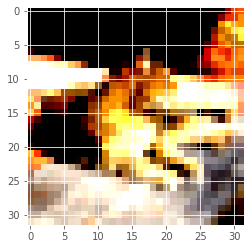

In [119]:
idx=-156
print(labels_dummy[idx])
plt.imshow(_[idx].permute(1, 2, 0))
